# Modelo 3 basado en Redes Neuronales

# Caso: Predicción de Empleabilidad de Graduados

En el presente cuaderno se abordará la tarea de clasificación de empleabilidad de graduados universitarios utilizando el [Graduate Employability Dataset de Kaggle](https://www.kaggle.com/datasets/sidraaazam/graduate-employability-dataset), que contiene información académica, habilidades y experiencias de estudiantes con el objetivo de predecir su colocación laboral. El objetivo principal es desarrollar y comparar el desempeño de una red neuronal MLP (Multilayer Perceptron) baseline con una versión mejorada, evaluando las diferencias en precisión y capacidad de generalización para identificar factores críticos que influyen en la empleabilidad.

Durante el desarrollo, se implementará una versión base de MLP que servirá como punto de referencia para analizar cómo la arquitectura procesa la información multidimensional de los graduados. Posteriormente, se propondrán mejoras sobre esta arquitectura inicial con el fin de optimizar el rendimiento del modelo, ya sea ajustando hiperparámetros, la profundidad de la red, aplicando técnicas de regularización o explorando diferentes estrategias de optimización que capturen las relaciones complejas entre las variables predictoras.

## Diccionario de Datos

| Variable | Descripción |
|----------|-------------|
| **College_ID** | Identificador único de la institución educativa |
| **IQ** | Puntuación de coeficiente intelectual del estudiante |
| **Prev_Sem_Result** | Resultado académico del semestre anterior |
| **CGPA** | Promedio académico acumulado |
| **Academic_Performance** | Puntuación de rendimiento académico general |
| **Internship_Experience** | Experiencia en pasantías (Sí/No) |
| **Extra_Curricular_Score** | Puntuación en actividades extracurriculares |
| **Communication_Skills** | Nivel de habilidades comunicativas |
| **Projects_Completed** | Número de proyectos académicos completados |
| **Placement** | Variable objetivo - Colocación laboral (Sí/No) |

## Cabeceras y Constantes

In [ ]:
import math
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers

## Lectura y Reporte del Dataset

In [ ]:
df = pd.read_csv('CollegePlacement.csv', delimiter=',')

In [ ]:
df.head()

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


In [ ]:
df.dtypes

,0
College_ID,object
IQ,int64
Prev_Sem_Result,float64
CGPA,float64
Academic_Performance,int64
Internship_Experience,object
Extra_Curricular_Score,int64
Communication_Skills,int64
Projects_Completed,int64
Placement,object


In [ ]:
# Eliminar College_ID (es un identificador sin valor predictivo)
df = df.drop('College_ID', axis=1)

In [ ]:
# Variables numéricas continuas
numeric_cols = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

# Variables categóricas
categoric_cols = ['Internship_Experience', 'Placement']

# DataFrames separados
numeric_df = df[numeric_cols]
categoric_df = df[categoric_cols]

## Exploración Inicial

### Variables Categóricas

In [ ]:
for col in categoric_cols:
    print(f'Columna {col}')
    print(f'Valores únicos: {categoric_df[col].unique()}\n')

Columna Internship_Experience
Valores únicos: ['No' 'Yes']

Columna Placement
Valores únicos: ['No' 'Yes']



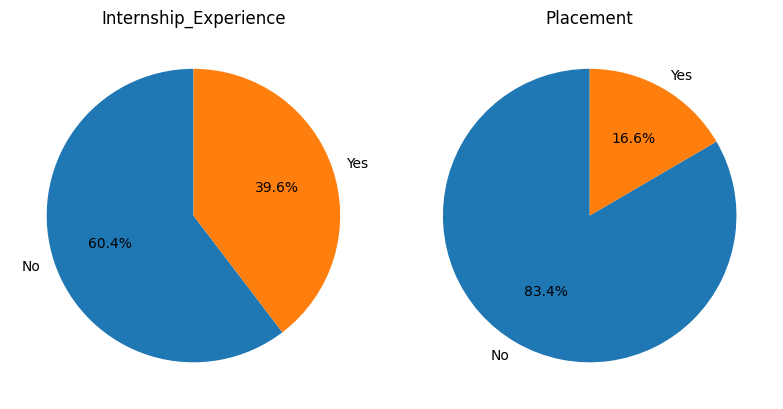

In [ ]:
# Preparar el gráfico
cols_per_row = 4
n_cols = len(categoric_cols)
n_rows = math.ceil(n_cols / cols_per_row)
plt.figure(figsize=(cols_per_row * 4, n_rows * 4))

# Mostrar la distribución por clase
for idx, col in enumerate(categoric_cols, 1):
    plt.subplot(n_rows, cols_per_row, idx)

    counts = categoric_df[col].value_counts()

    plt.pie(
        counts.values,
        labels=counts.index,
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title(col)

plt.tight_layout()
plt.show()


In [ ]:
# Codificar variables categóricas
# Para el dataset actual, se puede realizar OneHotEncoding a todas las columnas

# NOTA: Para Placement, considerar solo una columna si usamos drop_first=True
# ya que es binaria y evita multicolinealidad
df = pd.get_dummies(
    df,
    columns=categoric_cols,
    drop_first=True
)

In [ ]:
df.head(5)

,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Internship_Experience_Yes,Placement_Yes
0,107,6.61,6.28,8,8,8,4,False,False
1,97,5.52,5.37,8,7,8,0,False,False
2,109,5.36,5.83,9,3,1,1,False,False
3,122,5.47,5.75,6,1,6,1,True,False
4,96,7.91,7.69,7,8,10,2,False,False


In [ ]:
# Renombrar la variable objetivo
df['target'] = df['Placement_Yes']
df = df.drop('Placement_Yes', axis=1)

### Variables Numéricas

In [ ]:
numeric_df.describe()

,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99.471800,7.535673,7.532379,5.546400,4.970900,5.561800,2.513400
std,15.053101,1.447519,1.470141,2.873477,3.160103,2.900866,1.715959
min,41.000000,5.000000,4.540000,1.000000,0.000000,1.000000,0.000000
25%,89.000000,6.290000,6.290000,3.000000,2.000000,3.000000,1.000000
50%,99.000000,7.560000,7.550000,6.000000,5.000000,6.000000,3.000000
75%,110.000000,8.790000,8.770000,8.000000,8.000000,8.000000,4.000000
max,158.000000,10.000000,10.460000,10.000000,10.000000,10.000000,5.000000


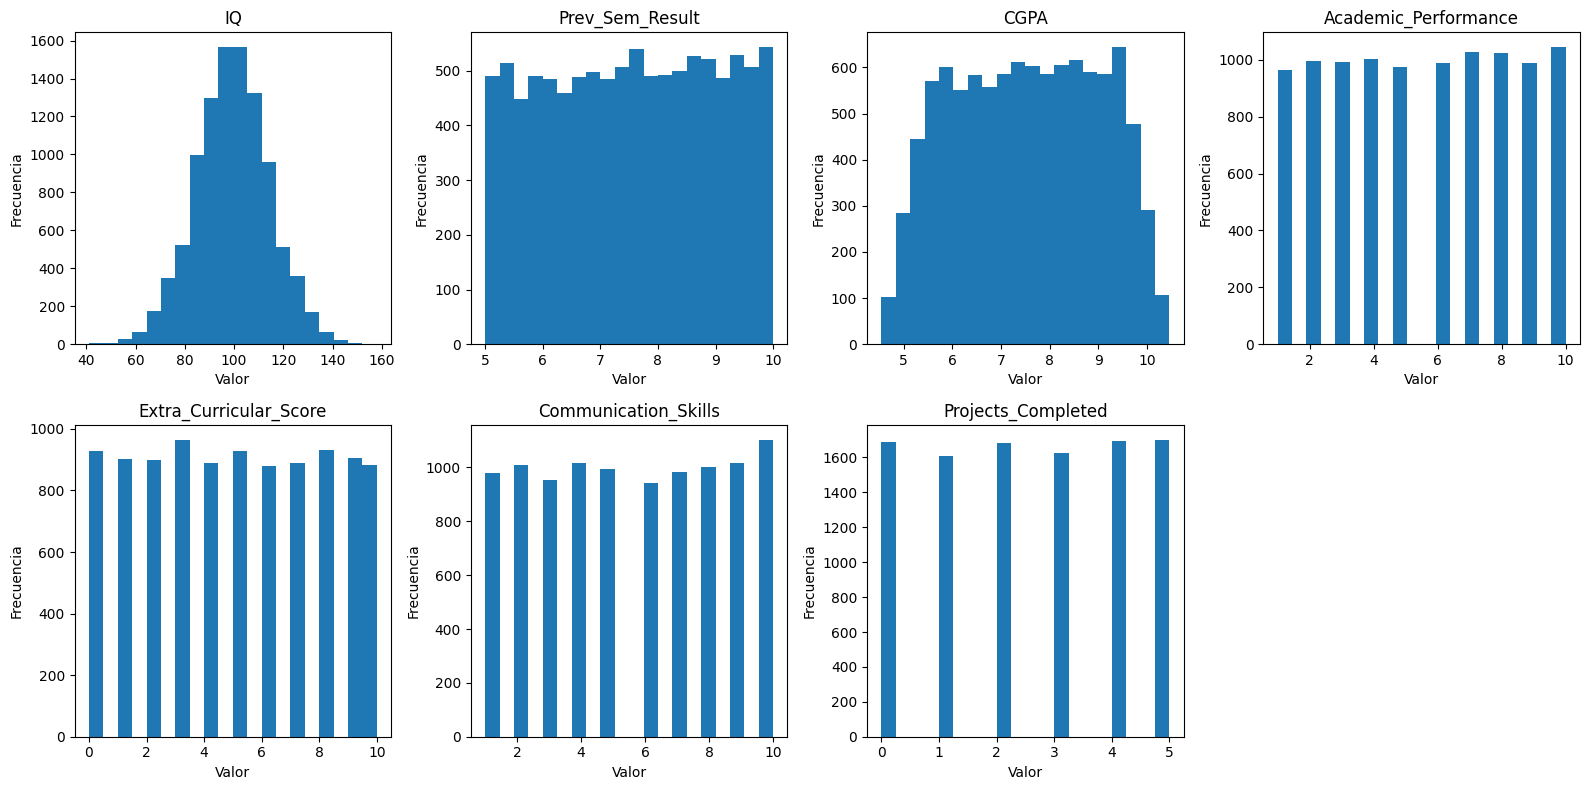

In [ ]:
cols_per_row = 4

n_cols = len(numeric_cols)
n_rows = math.ceil(n_cols / cols_per_row)

plt.figure(figsize=(cols_per_row * 4, n_rows * 4))

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, cols_per_row, idx)

    plt.hist(numeric_df[col].dropna(), bins=20)
    plt.title(col)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


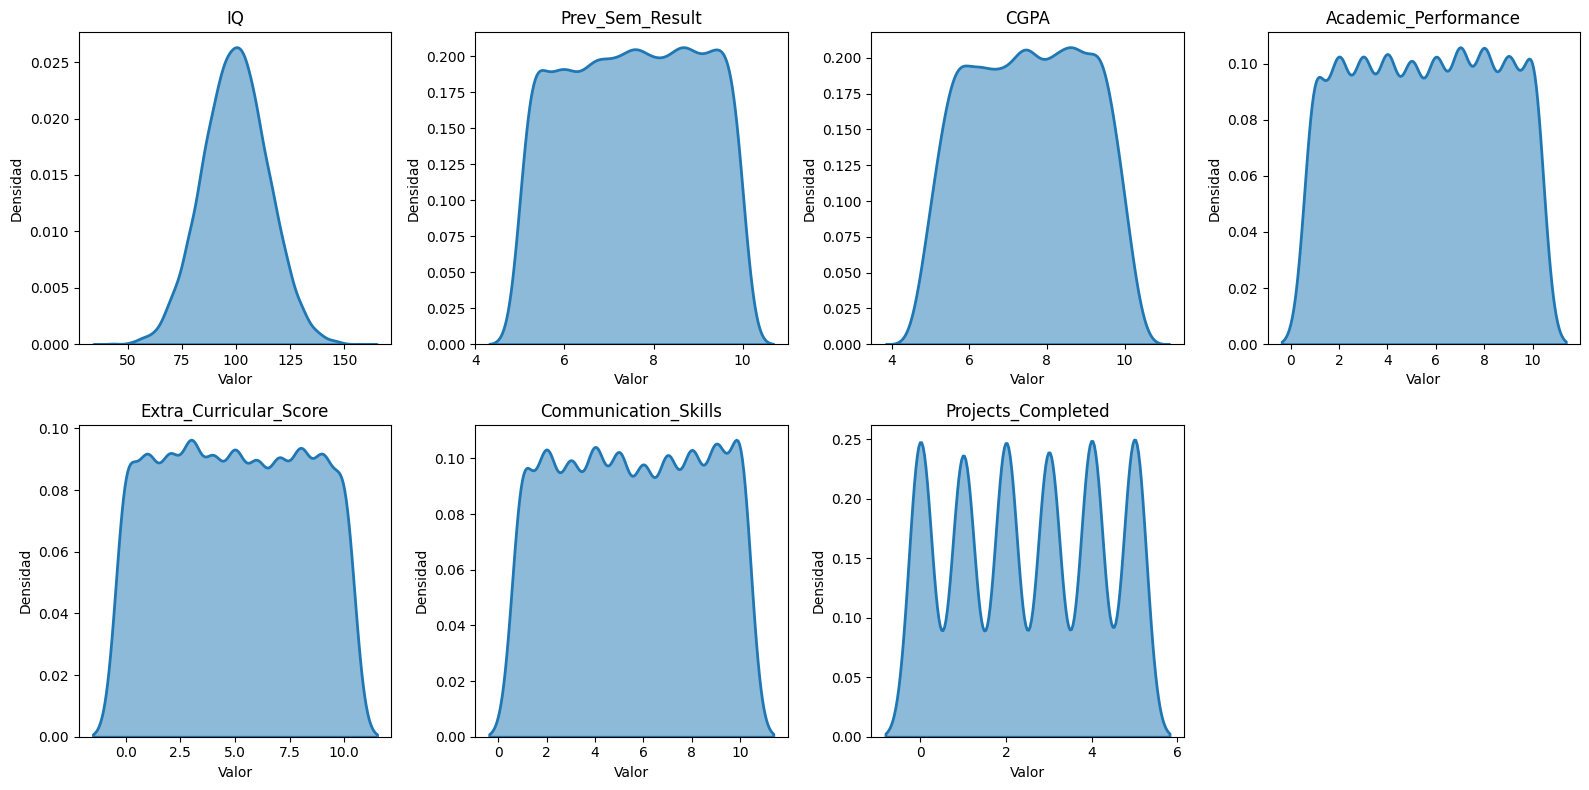

In [ ]:
cols_per_row = 4

n_cols = len(numeric_cols)
n_rows = math.ceil(n_cols / cols_per_row)

plt.figure(figsize=(cols_per_row * 4, n_rows * 4))

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, cols_per_row, idx)

    sns.kdeplot(
        data=numeric_df[col].dropna(),
        fill=True,
        alpha=0.5,
        linewidth=2
    )

    plt.title(col)
    plt.xlabel('Valor')
    plt.ylabel('Densidad')

plt.tight_layout()
plt.show()


## Definición de Conjuntos de Datos

In [ ]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
# Estandarizar variables numéricas
scaler = StandardScaler()

X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numeric_cols] = scaler.fit_transform(X_train_std[numeric_cols])
X_test_std[numeric_cols] = scaler.transform(X_test_std[numeric_cols])

## Modelo MLP Base

In [ ]:
def build_baseline_mlp(input_dim=8):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Capa oculta 1
        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),

        # Capa oculta 2
        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),

        # Capa de salida
        layers.Dense(1, activation='sigmoid')  # Clasificación binaria
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )

    return model

model = build_baseline_mlp()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del Modelo

In [ ]:
history = model.fit(X_train_std, y_train, validation_data=(X_test_std, y_test), batch_size=16, epochs=300)

Epoch 1/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9813 - auc: 0.9924 - loss: 0.0784 - precision: 0.9400 - recall: 0.9476 - val_accuracy: 0.9930 - val_auc: 0.9998 - val_loss: 0.0365 - val_precision: 0.9704 - val_recall: 0.9880
Epoch 2/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9865 - auc: 0.9955 - loss: 0.0606 - precision: 0.9570 - recall: 0.9599 - val_accuracy: 0.9945 - val_auc: 0.9980 - val_loss: 0.0385 - val_precision: 0.9908 - val_recall: 0.9759
Epoch 3/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9842 - auc: 0.9971 - loss: 0.0624 - precision: 0.9550 - recall: 0.9483 - val_accuracy: 0.9900 - val_auc: 0.9989 - val_loss: 0.0549 - val_precision: 0.9457 - val_recall: 0.9970
Epoch 4/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9846 - auc: 0.9972 - loss: 0.0629 - precision: 0.9426 - recall: 0.9670 - val_accuracy: 0.9940 - val_auc: 0.9997 - val_loss: 0.0415 - val_precision: 0.9790 - val_recall: 0.9849
Epoch 5/300
500/500 ━━━━━━━━

## Exploración de Resultados

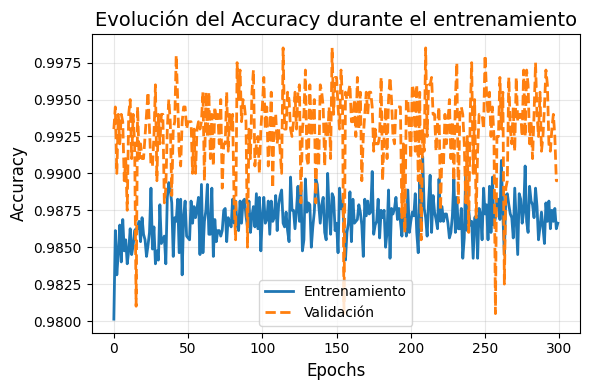

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(history.history['accuracy'],
         label='Entrenamiento',
         linewidth=2)

plt.plot(history.history['val_accuracy'],
         label='Validación',
         linewidth=2,
         linestyle='--')

plt.title('Evolución del Accuracy durante el entrenamiento', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


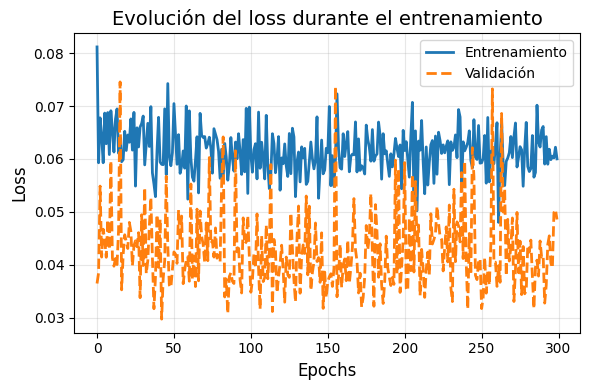

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(history.history['loss'],
         label='Entrenamiento',
         linewidth=2)

plt.plot(history.history['val_loss'],
         label='Validación',
         linewidth=2,
         linestyle='--')

plt.title('Evolución del loss durante el entrenamiento', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


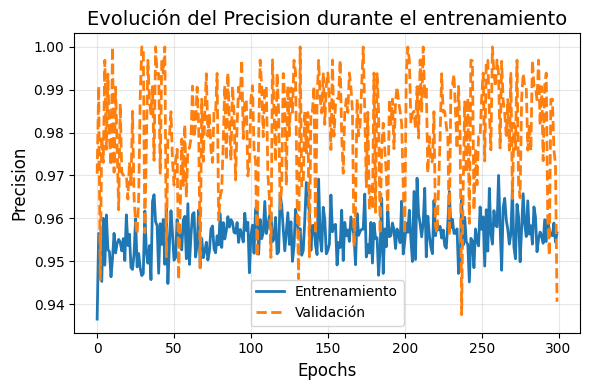

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(history.history['precision'],
         label='Entrenamiento',
         linewidth=2)

plt.plot(history.history['val_precision'],
         label='Validación',
         linewidth=2,
         linestyle='--')

plt.title('Evolución del Precision durante el entrenamiento', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

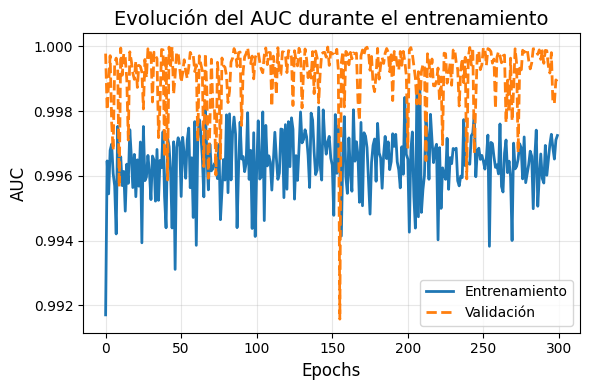

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(history.history['auc'],
         label='Entrenamiento',
         linewidth=2)

plt.plot(history.history['val_auc'],
         label='Validación',
         linewidth=2,
         linestyle='--')

plt.title('Evolución del AUC durante el entrenamiento', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('AUC', fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

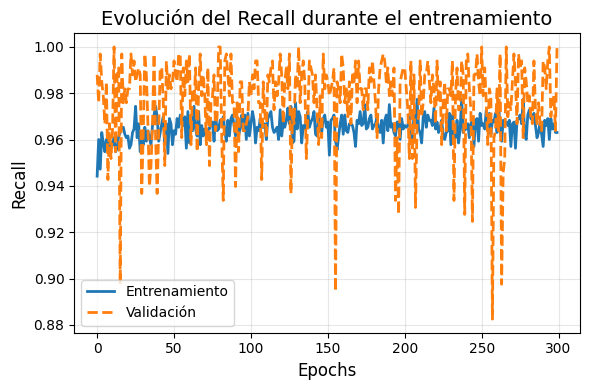

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(history.history['recall'],
         label='Entrenamiento',
         linewidth=2)

plt.plot(history.history['val_recall'],
         label='Validación',
         linewidth=2,
         linestyle='--')

plt.title('Evolución del Recall durante el entrenamiento', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el modelo en el test set
test_metrics = model.evaluate(X_test_std, y_test, verbose=0)

# Mapear los resultados con los nombres de las métricas
metric_names = ['loss', 'accuracy', 'auc', 'precision', 'recall']
print("\n=== MÉTRICAS EN TEST SET ===")
for name, value in zip(metric_names, test_metrics):
    print(f"{name}: {value:.4f}")


=== MÉTRICAS EN TEST SET ===
loss: 0.0486
accuracy: 0.9895
auc: 0.9989
precision: 0.9405
recall: 1.0000


In [ ]:
y_pred = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


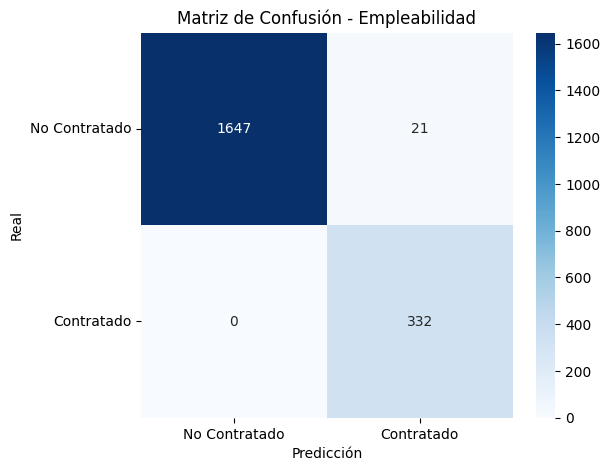

In [ ]:
y_pred_prob = model.predict(X_test_std)
y_pred_class = (y_pred_prob >= 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Empleabilidad")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks([0.5, 1.5], ["No Contratado", "Contratado"])
plt.yticks([0.5, 1.5], ["No Contratado", "Contratado"], rotation=0)

plt.show()

In [ ]:
# 1. Revisa si hay data leakage
print("¿Features correlacionadas con target?")
print(df.corr()['target'].sort_values(ascending=False))

# 2. Verifica distribución de train/test
print("\nDistribución en sets:")
print("Train - target:", y_train.mean())
print("Test - target:", y_test.mean())

# 3. Revisa si alguna feature es casi perfecta
for col in X.columns:
    correlation = df[col].corr(df['target'])
    if abs(correlation) > 0.8:
        print(f"ALTA CORRELACIÓN: {col} = {correlation:.4f}")

¿Features correlacionadas con target?
target                       1.000000
Communication_Skills         0.323155
CGPA                         0.321607
Prev_Sem_Result              0.317896
IQ                           0.285914
Projects_Completed           0.217499
Extra_Curricular_Score      -0.004740
Internship_Experience_Yes   -0.005841
Academic_Performance        -0.014920
Name: target, dtype: float64

Distribución en sets:
Train - target: 0.165875
Test - target: 0.166
